## The Premier League's Quarter Backs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats


from mplsoccer import Pitch

from PIL import Image
import urllib
import os

In [2]:
from matplotlib.font_manager import FontProperties

# Specify your font
regular = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Regular.ttf")  # Update the path to where the font is installed on your system
light = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Light.ttf")  # Update the path to where the font is installed on your system
bold = FontProperties(fname="C:\\Users\\George\\Documents\\Football Analytics\\Kanit-Bold.ttf")  # Update the path to where the font is installed on your system

In [3]:
league = 'Championship'

## Data

In [4]:
data = pd.read_csv('C:\\Users\\George\\Documents\\Football Analytics\\fotmob_Championship_data.csv')

In [5]:
data = data[data['position'] != 'GK']

In [6]:
data['value'].fillna(0, inplace=True)
numeric_column = pd.to_numeric(data['value'], errors='coerce')
# Find the indices of rows with NaN values in the numeric_column
nan_indices = numeric_column[numeric_column.isnull()].index
# Filter the original DataFrame to see the non-numeric values
non_numeric_values = data.loc[nan_indices]
data = data.drop(nan_indices)
data.reset_index(drop=True, inplace=True)
data['value'] = data['value'].astype(float)

In [7]:
data_minutes = (
    data[['player_id', 'minutes_played', 'match_id']].drop_duplicates()
    .groupby(['player_id'])['minutes_played'].sum()
    .reset_index()
)

data_groupped = (
    data.groupby(['team_name', 'team_id', 'player_id', 'full_name', 'variable'])
    ['value'].sum()
    .reset_index()
)

data_groupped = (
    pd.merge(data_groupped, data_minutes, how='left', on='player_id')
)

In [8]:
data_groupped = data_groupped[(data_groupped['variable'] == 'Accurate long balls') | (data_groupped['variable'] == 'Attempted long balls')].reset_index(drop=True)

In [9]:
df = data_groupped

In [10]:
data_groupped

,team_name,team_id,player_id,full_name,variable,value,minutes_played
0,Birmingham City,8658,27568,Lukas Jutkiewicz,Accurate long balls,2.0,550
1,Birmingham City,8658,27568,Lukas Jutkiewicz,Attempted long balls,9.0,550
2,Birmingham City,8658,172323,Kevin Long,Accurate long balls,42.0,1450
3,Birmingham City,8658,172323,Kevin Long,Attempted long balls,106.0,1450
4,Birmingham City,8658,190424,Scott Hogan,Accurate long balls,3.0,1006
...,...,...,...,...,...,...,...
1277,West Bromwich Albion,8659,1118483,Tom Fellows,Attempted long balls,9.0,1663
1278,West Bromwich Albion,8659,1298925,Jeremy Sarmiento,Accurate long balls,6.0,1353
1279,West Bromwich Albion,8659,1298925,Jeremy Sarmiento,Attempted long balls,11.0,1353
1280,West Bromwich Albion,8659,1327325,Callum Marshall,Accurate long balls,1.0,55


In [11]:
def agg_long_balls(group):
    return pd.Series({
        'minutes': group['minutes_played'].iloc[0],
        'long_balls_succ': group.loc[group['variable'] == 'Accurate long balls', 'value'].sum(),
        'long_balls_att': group.loc[group['variable'] == 'Attempted long balls', 'value'].sum()
    })

df = (
    df.groupby(['player_id', 'full_name'])
    .apply(agg_long_balls)
    .reset_index()
)

In [12]:
df

,player_id,full_name,minutes,long_balls_succ,long_balls_att
0,10879,Luke McNally,3201.0,89.0,219.0
1,13917,Liam Kelly,892.0,28.0,54.0
2,23229,Billy Sharp,327.0,2.0,4.0
3,27568,Lukas Jutkiewicz,550.0,2.0,9.0
4,37194,Erik Pieters,1577.0,46.0,87.0
...,...,...,...,...,...
611,1572356,Joseph James,77.0,0.0,3.0
612,1573605,Sam Parker,140.0,0.0,3.0
613,1575429,Tom Iorpenda,50.0,0.0,1.0
614,1605701,Raheem Conte,90.0,5.0,7.0


We filter players above the median in both minutes and long balls attempted.

In [13]:
df_plot = df[(df['minutes'] >= df['minutes'].median()) & (df['long_balls_att'] >= df['long_balls_att'].median())]
df_plot

,player_id,full_name,minutes,long_balls_succ,long_balls_att
0,10879,Luke McNally,3201.0,89.0,219.0
4,37194,Erik Pieters,1577.0,46.0,87.0
5,40567,Lee Peltier,1840.0,57.0,148.0
6,46354,Jonathan Howson,3097.0,94.0,192.0
16,115681,Jake Livermore,2074.0,60.0,111.0
...,...,...,...,...,...
577,1310975,Jordan James,2298.0,49.0,102.0
580,1323305,Archie Gray,3870.0,42.0,114.0
589,1350598,Dexter Lembikisa,2005.0,28.0,98.0
592,1367702,Brodie Spencer,1536.0,20.0,77.0


In [14]:
df_plot = df_plot.assign(per_90 = lambda x: (x.long_balls_att/x.minutes)*90)
df_plot = df_plot.assign(succ_rate = lambda x: x.long_balls_succ/x.long_balls_att)

In [15]:
df_plot.sort_values(by='per_90')

,player_id,full_name,minutes,long_balls_succ,long_balls_att,per_90,succ_rate
167,519835,Adam Armstrong,4012.0,24.0,49.0,1.099202,0.489796
397,941213,Crysencio Summerville,3752.0,26.0,46.0,1.103412,0.565217
288,759580,Stephy Mavididi,3598.0,27.0,46.0,1.150639,0.586957
275,734042,Kyle Walker-Peters,4130.0,29.0,56.0,1.220339,0.517857
99,290409,Will Keane,2627.0,25.0,38.0,1.301865,0.657895
...,...,...,...,...,...,...,...
57,198265,Ryan Leonard,2711.0,92.0,305.0,10.125415,0.301639
255,694558,Dominic Hyam,3016.0,189.0,347.0,10.354775,0.544669
22,156013,Steve Cook,3071.0,187.0,409.0,11.986324,0.457213
325,798603,Ben Wilmot,2042.0,144.0,303.0,13.354554,0.475248


Now, we compute a basic z-score index for the colormap.

In [16]:
df_plot['zscore'] = stats.zscore(df_plot['per_90'])*.4 + stats.zscore(df_plot['succ_rate'])*.6
df_plot['annotated'] = [True if x > df_plot['zscore'].quantile(.8) else False for x in df_plot['zscore']]

## The Viz

In [17]:
df_plot.reset_index(drop=True, inplace=True)

In [18]:
todays_date = pd.to_datetime('today').strftime('%d %B %Y')

In [19]:
annotated_df = df_plot[df_plot['annotated']].reset_index(drop=True)

In [20]:
for x in range(0, len(annotated_df)):
    if len(annotated_df['full_name'][x].split(' ')) > 1:
        annotated_df['full_name'][x] = ' '.join(annotated_df['full_name'].iloc[x].split(' ')[1:])
    elif len(annotated_df['full_name'][x].split(' ')) > 3:
        annotated_df['full_name'][x] = ' '.join(annotated_df['full_name'].iloc[x].split(' ')[2:])
    else:
        annotated_df['full_name'][x] = annotated_df['full_name'][x]

C:\Users\dmsta\AppData\Local\Temp\ipykernel_20376\3261604906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated_df['full_name'][x] = ' '.join(annotated_df['full_name'].iloc[x].split(' ')[1:])
C:\Users\dmsta\AppData\Local\Temp\ipykernel_20376\3261604906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotated_df['full_name'][x] = ' '.join(annotated_df['full_name'].iloc[x].split(' ')[1:])
C:\Users\dmsta\AppData\Local\Temp\ipykernel_20376\3261604906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

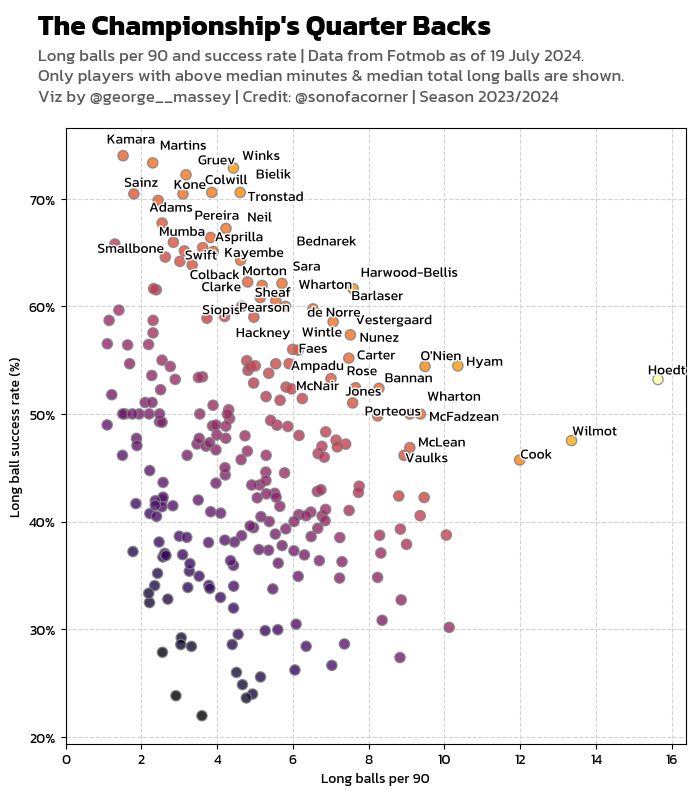

In [22]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.subplot()
ax.grid(visible=True, ls='--', color='lightgrey')

ax.scatter(
    df_plot['per_90'], df_plot['succ_rate'], 
    c=df_plot['zscore'], cmap='inferno', 
    zorder=3, ec='grey', s=55, alpha=0.8)
    
texts = []
for index in range(annotated_df.shape[0]):
    texts += [
        ax.text(
            x=annotated_df['per_90'].iloc[index], y=annotated_df['succ_rate'].iloc[index],
            s=annotated_df['full_name'].iloc[index],
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            fontproperties = regular, weight='bold'
        )
    ]

adjust_text(texts, only_move={'points':'y', 'text':'xy', 'objects':'xy'})

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax.set_xlim(0)
#ax.set_ylim(0,1)

ax.set_ylabel('Long ball success rate (%)', fontproperties = regular)
ax.set_xlabel('Long balls per 90', fontproperties = regular)
plt.xticks(fontproperties = regular)
plt.yticks(fontproperties = regular)

fig_text(
    x = 0.09, y = .99, 
    s = f"The {league}'s Quarter Backs",
    va = "bottom", ha = "left",
    fontsize = 20, color = "black", fontproperties = bold, weight = "bold"
)

fig_text(
    x = 0.09, y = 0.91, 
    s = f"Long balls per 90 and success rate | Data from Fotmob as of {todays_date}.\nOnly players with above median minutes & median total long balls are shown.\nViz by @george__massey | Credit: @sonofacorner | Season 2023/2024",
    va = "bottom", ha = "left",
    fontsize = 12, color = "#5A5A5A", fontproperties = regular
)

plt.savefig(
	f"C:\\Users\\George\\Documents\\Football Analytics\\Visuals\\{league} Quarter Backs.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

